In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [2]:
diagnosis_data = pd.read_csv('Diagnosisdata.csv') 
hospital_data = pd.read_csv('Hospitaldata.csv') 
patient_data = pd.read_csv('Patientdata.csv') 

In [3]:
all_features = diagnosis_data.merge(hospital_data,on=['patientID','istrain']).merge(patient_data,on=['patientID','istrain'])

In [4]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31513 entries, 0 to 31512
Data columns (total 41 columns):
patientID                  31513 non-null object
num_procedures             31513 non-null int64
num_medications            31513 non-null int64
num_diagnoses              31513 non-null int64
max_glu_serum              31513 non-null object
A1Cresult                  31513 non-null object
metformin                  31513 non-null object
repaglinide                31513 non-null object
nateglinide                31513 non-null object
chlorpropamide             31513 non-null object
glimepiride                31513 non-null object
acetohexamide              31513 non-null object
glipizide                  31513 non-null object
glyburide                  31513 non-null object
tolbutamide                31513 non-null object
pioglitazone               31513 non-null object
rosiglitazone              31513 non-null object
acarbose                   31513 non-null object
miglitol    

In [5]:
# admissionID is only identifier
all_features = all_features.drop(columns=['AdmissionID'])

In [6]:
# Missing values:
# weight has too less values. It cannot be used as a feature
all_features = all_features.drop(columns='weight')

In [7]:
all_c = all_features

In [8]:
# payer code and medical specialty have missing values
print(all_features.shape)
print(all_features['payer_code'].value_counts())
print(all_features['medical_specialty'].value_counts())

(31513, 39)
PC8     8916
PC7     1812
PC1     1758
PC15    1487
PC9      968
PC4      941
PC16     934
PC3      596
PC11     323
PC13     239
PC5      142
PC2       64
PC17      60
PC12      21
PC14      21
PC10      20
PC6        1
Name: payer_code, dtype: int64
InternalMedicine                        4868
Family/GeneralPractice                  2213
Cardiology                              1834
Emergency/Trauma                        1833
Surgery-General                          997
Orthopedics                              558
Orthopedics-Reconstructive               528
Radiologist                              376
ObstetricsandGynecology                  331
Nephrology                               312
Psychiatry                               305
Pulmonology                              276
Urology                                  264
Surgery-Cardiovascular/Thoracic          252
Surgery-Neuro                            213
Gastroenterology                         195
Surgery-Vascular

In [9]:
cols_to_impute = all_features[['payer_code','medical_specialty']]
cols_to_impute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31513 entries, 0 to 31512
Data columns (total 2 columns):
payer_code           18303 non-null object
medical_specialty    16575 non-null object
dtypes: object(2)
memory usage: 738.6+ KB


In [10]:
# Impute with most frequent occuring value
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="most_frequent")
imputed_cols = pd.DataFrame(imp.fit_transform(cols_to_impute))

In [11]:
all_features['payer_code'] = imputed_cols[0]
all_features['medical_specialty'] = imputed_cols[1]

In [12]:
all_features.columns

Index(['patientID', 'num_procedures', 'num_medications', 'num_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide.metformin', 'glipizide.metformin', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'istrain',
       'Admission_date', 'Discharge_date', 'admission_type_id',
       'admission_source_id', 'payer_code', 'medical_specialty', 'race',
       'gender', 'age', 'Target'],
      dtype='object')

In [13]:
# combine admission date and discharge date cols to duration of stay
date_list = ['Admission_date','Discharge_date']
for col in date_list:
    all_features[col] = all_features[col].astype('datetime64')

In [14]:
all_features['duration_of_stay'] = all_features['Discharge_date'] - all_features['Admission_date']
all_features['duration_of_stay'] = all_features['duration_of_stay']/np.timedelta64(1, 'D')
all_features = all_features.drop(columns=date_list)

In [15]:
all_features.columns

Index(['patientID', 'num_procedures', 'num_medications', 'num_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide.metformin', 'glipizide.metformin', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'istrain',
       'admission_type_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'race', 'gender', 'age', 'Target',
       'duration_of_stay'],
      dtype='object')

In [16]:
for col in all_features.columns:
    print(col)
    print(all_features[col].unique())

patientID
['PT456611' 'PT956824' 'PT453330' ... 'PT247544' 'PT610717' 'PT859520']
num_procedures
[0 1 2 3 6 5 4]
num_medications
[11  6 27 10 12  7 16  5 15 26 13  4 20 25 19  9 24 21 14 22 17  3 43  8
 18 31 23 28 35  2 60 46 30 33 34 38 29 48 37 39 32 41 55  1 42 51 53 45
 40 36 47 44 58 49 56 63 50 52 59 64 57 54 68 72 62 65 61 81 70 67]
num_diagnoses
[ 9  6  5  8  3  4  7  2  1 16 10 13 12 15 14]
max_glu_serum
['None' '>200' 'Norm' '>300']
A1Cresult
['None' '>8' 'Norm' '>7']
metformin
['No' 'Steady' 'Up' 'Down']
repaglinide
['No' 'Steady' 'Up' 'Down']
nateglinide
['No' 'Steady' 'Down' 'Up']
chlorpropamide
['No' 'Steady' 'Up' 'Down']
glimepiride
['No' 'Steady' 'Up' 'Down']
acetohexamide
['No']
glipizide
['No' 'Steady' 'Up' 'Down']
glyburide
['No' 'Steady' 'Up' 'Down']
tolbutamide
['No' 'Steady']
pioglitazone
['No' 'Steady' 'Up' 'Down']
rosiglitazone
['Steady' 'No' 'Up' 'Down']
acarbose
['No' 'Steady' 'Up']
miglitol
['No' 'Steady']
troglitazone
['No' 'Steady']
tolazamide
['No' 'Stead

In [17]:
# acetohexamide and metformin.rosiglitazone have same value for all samples. So it can be skipped from feature selection
all_features = all_features.drop(columns=['acetohexamide','metformin.rosiglitazone'])

In [18]:
high_cardinality =['num_medications', 'num_diagnoses', 'admission_source_id', 'duration_of_stay', 'payer_code', 'medical_specialty',]
numerical_categorical = ['num_procedures', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'metformin.pioglitazone', 'change', 'diabetesMed', 'admission_type_id', 'race', 'gender', 'age', 'Target']

In [19]:
# # convert numerical data types to int/float
# categorical_features = ['payer_code','medical_specialty','race','gender','age','max_glu_serum','A1Cresult','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'metformin.rosiglitazone', 'metformin.pioglitazone','change', 'diabetesMed','Target']
# numerical_features = ['admission_type_id','admission_source_id','num_procedures','num_medications','num_diagnoses','istrain']
# # loan_data.columns[loan_data.dtypes!=object].tolist()
cat = all_features.columns[all_features.dtypes==object].tolist()
# num = all_features.columns[all_features.dtypes!=object].tolist()
# # types of categorical features
nominal = ['max_glu_serum','A1Cresult','payer_code','medical_specialty','race','age']
ordinal = ['insulin','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide','pioglitazone', 'rosiglitazone', 'acarbose','glyburide.metformin']
binary = ['gender','Target','tolbutamide','miglitol', 'troglitazone', 'tolazamide','glipizide.metformin','metformin.pioglitazone','change','diabetesMed']

In [20]:
# label encoding
le = LabelEncoder()
oc = OrdinalEncoder()

for col in nominal:
    all_features[col] = le.fit_transform(all_features[col])

all_features[ordinal] = oc.fit_transform(all_features[ordinal])

In [21]:
# get dummies
all_features[binary] = pd.get_dummies(all_features[binary],columns=binary,drop_first=True)

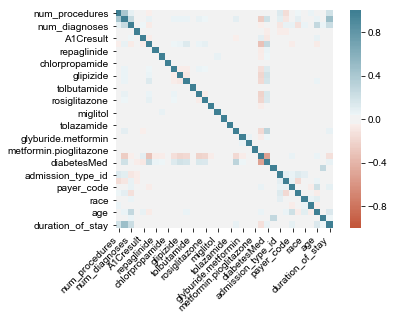

In [22]:
# correlation heatmap
corr = all_features.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(11,11)})

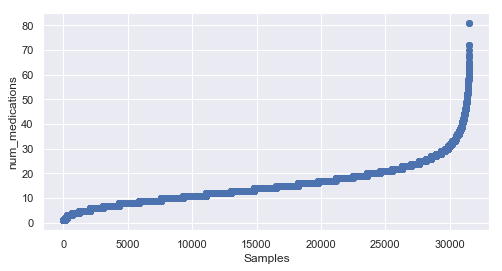

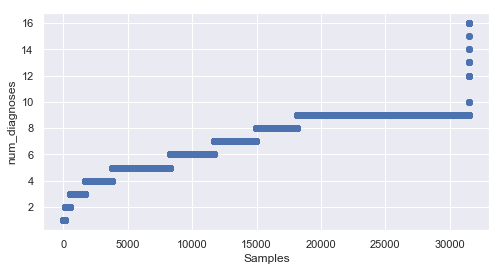

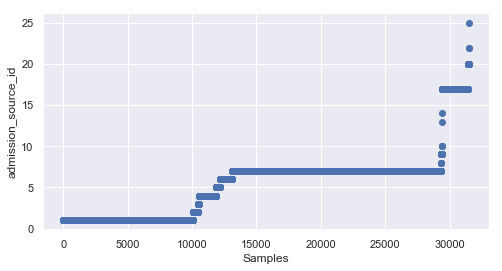

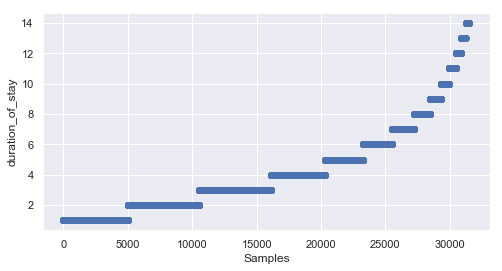

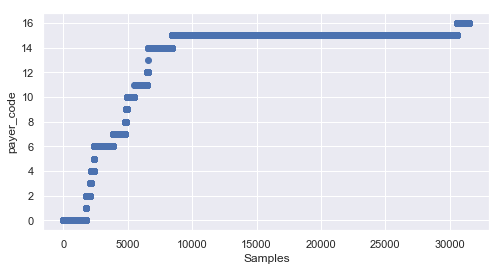

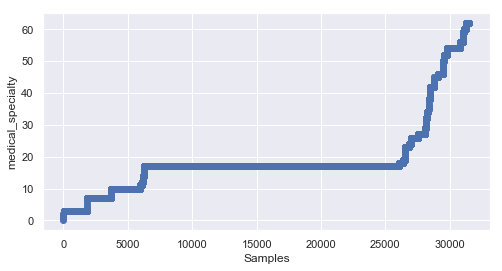

In [23]:
# high_cardinality
for y in high_cardinality:
    plt.figure(figsize=(8,4))
    plt.scatter(range(all_features.shape[0]), np.sort(all_features[y].values))
    plt.xlabel('Samples')
    plt.ylabel(y)
    plt.show();

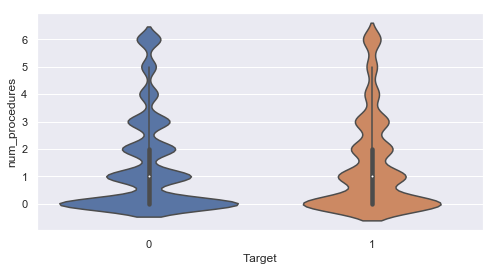

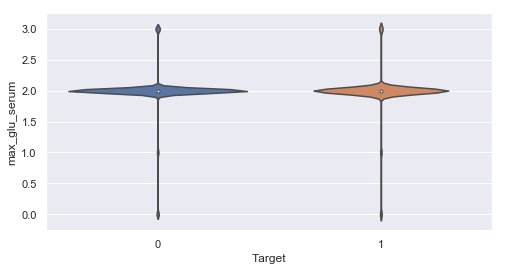

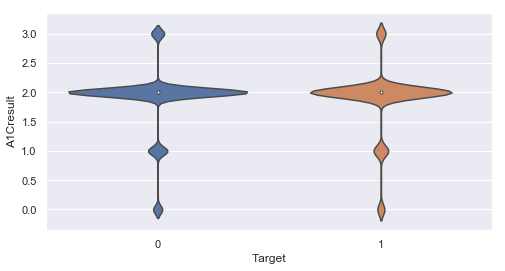

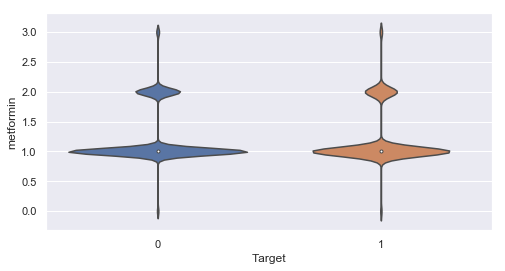

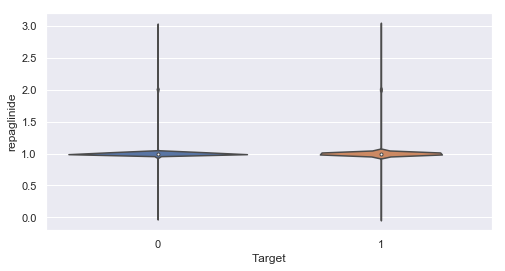

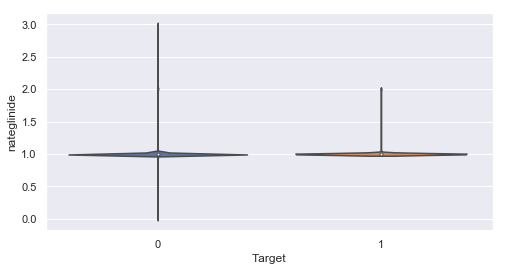

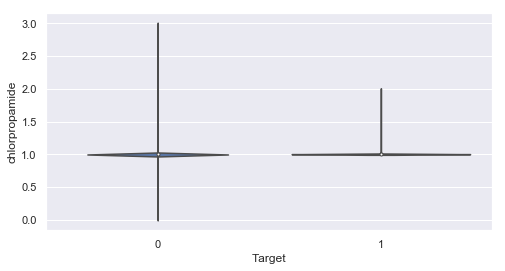

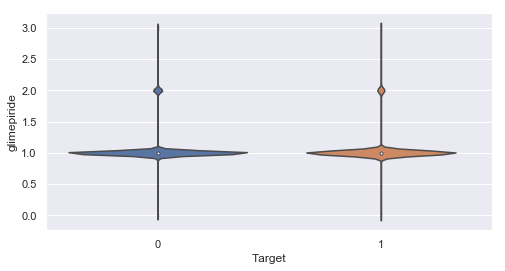

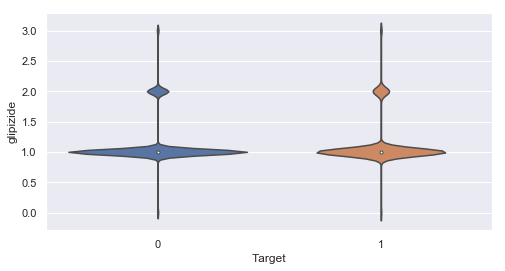

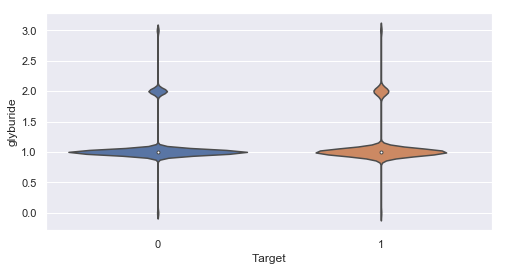

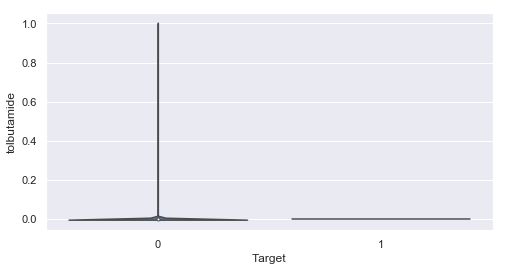

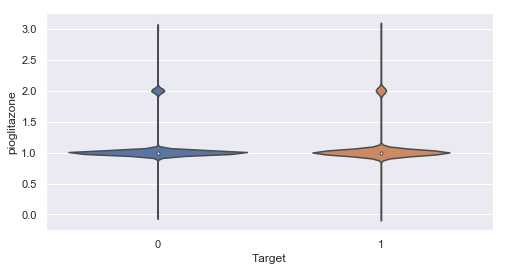

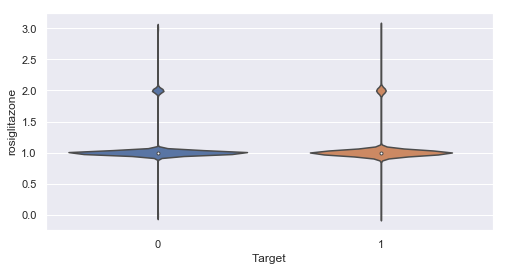

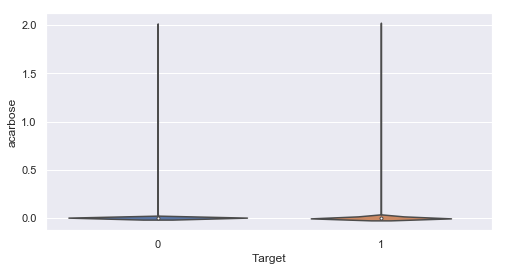

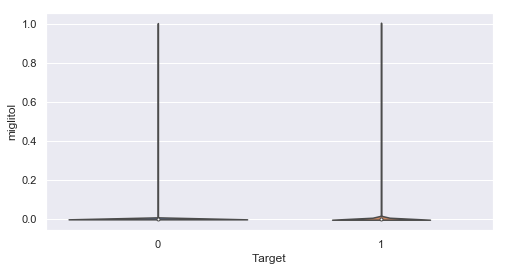

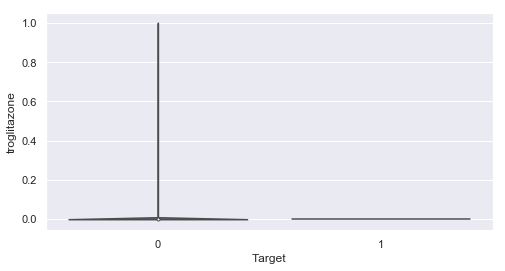

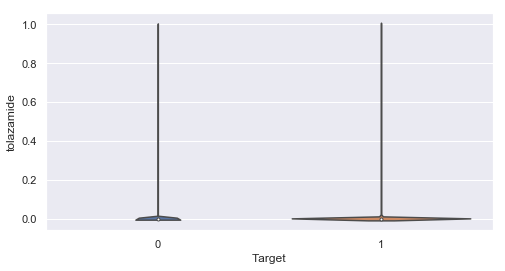

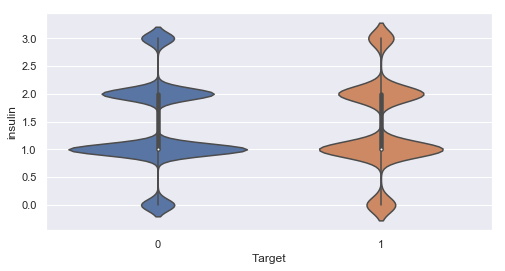

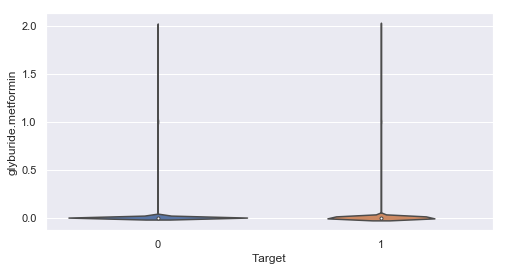

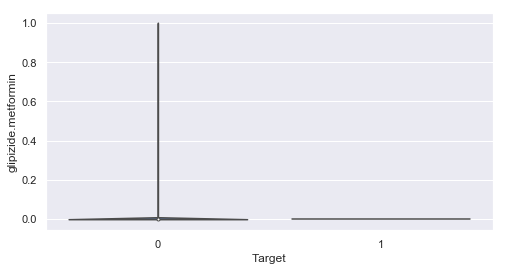

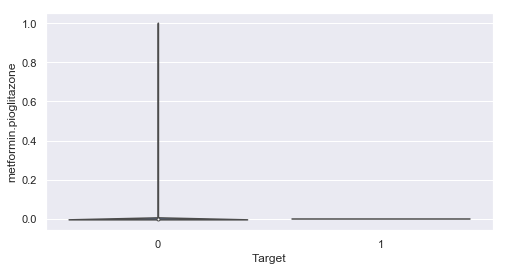

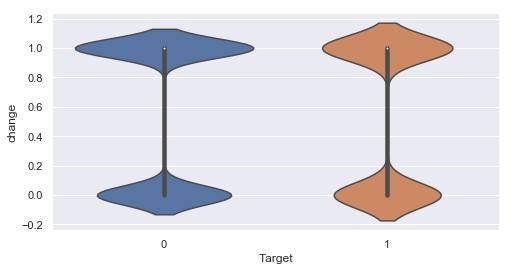

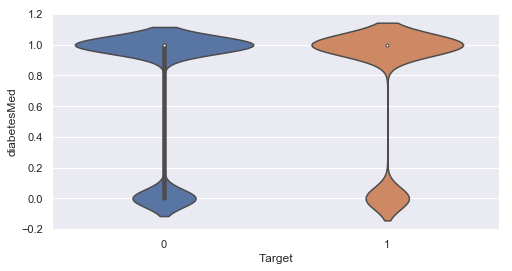

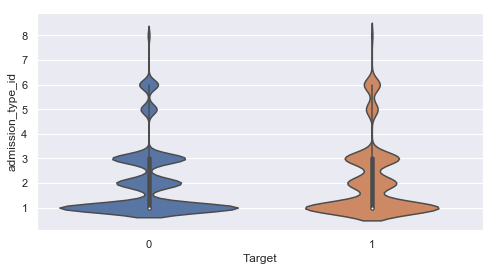

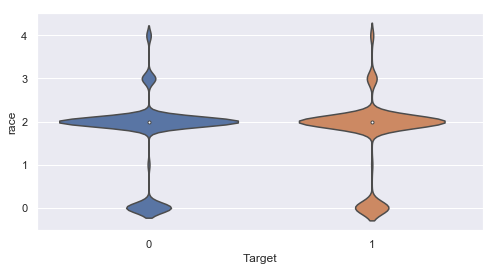

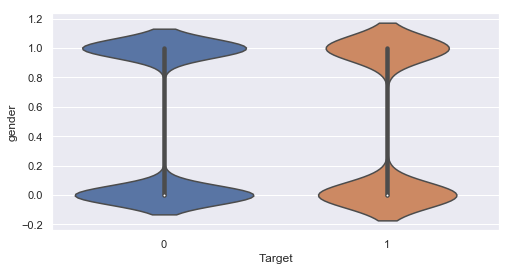

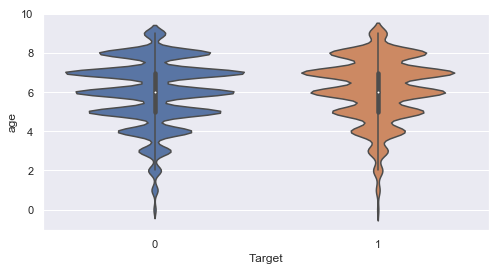

In [24]:
# ordinal:
for y in numerical_categorical[:-1]:
    plt.figure(figsize=(8,4))
    sns.violinplot(x=all_features.Target, y=y, data=all_features)
    plt.xlabel('Target', fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.show();

In [25]:
upper_outliers = ['repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'glyburide.metformin', 'glipizide.metformin', 'metformin.pioglitazone']
lower_outliers = ['max_glu_serum']

In [26]:
for col in upper_outliers:
    upper_value = np.percentile(all_features[col].values, 98)
    change = all_features.loc[all_features[col] > upper_value, col].shape[0]
    all_features.loc[all_features[col] > upper_value, col] = upper_value
    print('Fixed {} or {:.2f}% upper outliers. '.format(change, change/all_features.shape[0]*100))

for col in lower_outliers:
    lower_value = np.percentile(all_features[col].values, 98)
    change = all_features.loc[all_features[col] < upper_value, col].shape[0]
    all_features.loc[all_features[col] < upper_value, col] = upper_value
    print('Fixed {} or {:.2f}% lower outliers. '.format(change, change/all_features.shape[0]*100))

Fixed 367 or 1.16% upper outliers. 
Fixed 197 or 0.63% upper outliers. 
Fixed 28 or 0.09% upper outliers. 
Fixed 103 or 0.33% upper outliers. 
Fixed 6 or 0.02% upper outliers. 
Fixed 75 or 0.24% upper outliers. 
Fixed 66 or 0.21% upper outliers. 
Fixed 97 or 0.31% upper outliers. 
Fixed 3 or 0.01% upper outliers. 
Fixed 1 or 0.00% upper outliers. 
Fixed 13 or 0.04% upper outliers. 
Fixed 193 or 0.61% upper outliers. 
Fixed 1 or 0.00% upper outliers. 
Fixed 2 or 0.01% upper outliers. 
Fixed 0 or 0.00% lower outliers. 


In [27]:
all_train_features = all_features[all_features['istrain']==1]
all_test_features = all_features[all_features['istrain']==0]
all_train_features = all_train_features.drop(columns='istrain')
all_test_features = all_test_features.drop(columns='istrain')

In [28]:
# all_train_data.columns
X = all_train_features.drop(columns=['patientID','Target'])
y = all_train_features['Target']

In [29]:
"""
Model evaluation across multiple classifiers based on accuracy of predictions.
"""
classifiers = [
    KNeighborsClassifier(3),
    LinearSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LogisticRegression()]

acc_dict = {}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += (acc/10.0)
        else:
            acc_dict[name] = (acc/10.0)

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\li

In [30]:
acc_dict

{'KNeighborsClassifier': 0.645548227535037,
 'LinearSVC': 0.6140560593569662,
 'DecisionTreeClassifier': 0.5991755976916735,
 'RandomForestClassifier': 0.7079967023907666,
 'AdaBoostClassifier': 0.7328112118713933,
 'GradientBoostingClassifier': 0.7327287716405605,
 'GaussianNB': 0.2673948887056884,
 'LogisticRegression': 0.7333058532563892}